## Modules & Functions

In [1]:
# import sys
import numpy as np
from scipy.stats import norm
import pandas as pd
import gc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, FoVBackgroundModel, Models, SmoothBrokenPowerLawSpectralModel
from gammapy.estimators import FluxPoints,FluxPointsEstimator, ExcessMapEstimator
%matplotlib inline
import sys, os
import numpy as np
import itertools
import re
import datetime
import gammapy
import time
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec
import json
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import CashCountsStatistic, cash, cash_sum_cython
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets, FluxPointsDataset, MapDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, DiskSpatialModel, TemplateSpatialModel, PowerLawNormSpectralModel, BrokenPowerLawSpectralModel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion, EllipseSkyRegion
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
    EnergyDependentMorphologyEstimator)
# from common_utils import get_excluded_regions
#from gammapy.utils.regions import make_region
from gammapy.modeling.models import FoVBackgroundModel, GaussianSpatialModel, ShellSpatialModel, DiskSpatialModel, PiecewiseNormSpectralModel, GeneralizedGaussianSpatialModel, ExpCutoffPowerLawSpectralModel
from gammapy.makers import FoVBackgroundMaker, RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxMaps
from gammapy.maps import WcsNDMap
from gammapy.visualization import plot_npred_signal, plot_distribution
import ipywidgets
from gammapy.modeling.models import Models
from astropy.coordinates import Angle
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
from scipy.stats import chi2, norm
from astropy.table import Table
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import aplpy
import matplotlib.pyplot as mpl
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import sys  
sys.path.insert(1, '/home/hpc/caph/mppi103h/Documents/On-OFF-matching-woody')
from scipy.optimize import curve_fit
import common_utils
from common_utils import get_excluded_regions
from matplotlib.lines import Line2D
from PIL import Image
sys.path.insert(1, '/home/wecapstor1/caph/caph101h/projects/test_projects/HAWC_J0543+233/python_scripts/')
import my_utility_functions as muf
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.catalog import SourceCatalog4FGL
import os
import re
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy import table
import runmatching_utilities as util

In [2]:
PlotDir = '/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Plots/Ring/'

In [3]:
from gammapy.modeling.models import TemplateSpatialModel
from gammapy.maps import Map

def make_template_spatial_model_from_excess(result):
    # Retrieve the excess map
    excess_map = result.npred_excess
    
    # Apply the spatial and energy mask
    masked_excess_map = excess_map 
    
    # Collapse over energy axis
    collapsed_map_data = masked_excess_map.sum_over_axes().data
    
    # Replace negative values with a small constant
    epsilon = 1e-10
    collapsed_map_data[collapsed_map_data < 0] = epsilon
    
    # Create a 2D spatial map
    collapsed_map = Map.from_geom(masked_excess_map.geom.to_image(), data=collapsed_map_data)
    
    # Generate the TemplateSpatialModel
    spatial_model = TemplateSpatialModel(map=collapsed_map, normalize=True)
    
    return spatial_model

def sexagesimal_to_ra_dec(ra_sexagesimal, dec_sexagesimal):
    """
    Converts RA and Dec from sexagesimal format (HH:MM:SS, DD:MM:SS) to decimal degrees.
    
    Parameters:
    - ra_sexagesimal: str
        Right Ascension in sexagesimal format (e.g., "07h00m28.8s").
    - dec_sexagesimal: str
        Declination in sexagesimal format (e.g., "+14d19m12.0s").

    Returns:
    - ra: float
        Right Ascension in decimal degrees.
    - dec: float
        Declination in decimal degrees.
    """
    # Create a SkyCoord object from sexagesimal inputs
    sky_coord = SkyCoord(ra=ra_sexagesimal, dec=dec_sexagesimal, frame='icrs')
    
    # Extract RA and Dec in decimal degrees
    ra = sky_coord.ra.deg
    dec = sky_coord.dec.deg
    
    return ra, dec

In [36]:
def gaussian(x, amplitude, mean, stddev):
    """
    Gaussian function.
    
    Parameters:
    - x: Independent variable
    - amplitude: Peak value of the Gaussian
    - mean: Mean (center) of the Gaussian
    - stddev: Standard deviation (width) of the Gaussian
    
    Returns:
    - Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

def fit_gaussian(x_data, y_data):
    """
    Fits a Gaussian normal distribution to the given data.
    
    Parameters:
    - x_data: Array of x values
    - y_data: Array of y values
    
    Returns:
    - popt: Optimal values for the Gaussian parameters (amplitude, mean, stddev)
    - pcov: Covariance of the parameters
    """
    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [np.mean(y_data), 0, 1]
    
    # Fit the Gaussian to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    error = np.diag(np.sqrt(pcov))
    return popt, error

In [4]:
def chi2_(A, B):
    chi = np.sum([((a - b) ** 2) / (b) for (a, b) in zip(A, B)])
    return chi

def chi_squared_calculator(flux_points, sky_model):
    """
    Calculate chi-squared between observed flux points and model predictions.

    Parameters:
    - flux_points: FluxPoints object containing the observed flux points data.
    - model: Spectral model object to compare with flux points.
    - delta_e: Small energy range around each flux point for flux prediction (default: 0.1 TeV).
    
    Returns:
    - chi2_values: List of chi-squared values for each flux point.
    """
    # Extract the observed flux and energy data
    mask = np.isfinite(flux_points.e2dnde.data[:, 0, 0])  # Filter out non-finite values
    observed_flux = flux_points.e2dnde.data[mask][:, 0, 0]  # Observed flux values
    energy_axis = flux_points.energy_axis

    predicted_flux = sky_model.spectral_model.reference_fluxes(energy_axis)["ref_e2dnde"] * u.Unit("cm2 s / TeV")

    result = chi2_(observed_flux, predicted_flux)

    exponents = np.floor(np.log10(observed_flux, predicted_flux))
    unique_exponents, counts = np.unique(exponents, return_counts=True)

    # Find the most common exponent
    most_common_exponent = unique_exponents[np.argmax(counts)]

    # Automate the multiplier based on the exponent
    result *= 10**(-most_common_exponent)
   
    return result

def source_regions_plot(_ax_, _catalog_, _marker_):
    """
    Plot all sources within 4 deg of ra, dec = (160.81, -58.85)
    """
    for index in range(len(_catalog_.table)):
        ra = _catalog_.table[index]["RAJ2000"]
        dec = _catalog_.table[index]["DEJ2000"]
        name = _catalog_.table[index]["Source_Name"]

        position = SkyCoord(ra, dec, frame='icrs', unit='deg')
        _ax_.text(position.ra.deg+.75, position.dec.deg+.1, name, weight='bold',color=_marker_['color'],transform=_ax_.get_transform('world'))
        _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

def plot_spectrum(model, flux_points, energy_power, label, color):
    spec = model.spectral_model
    energy_range = [.1, 100] * u.TeV
    
    if energy_power == 0:
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
        plt.grid()
        plt.xlim(1e-1,1e2)

    else:   
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'E$^{%d}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]' % energy_power)
        plt.xlim(1e-1,1e2)

def find_energy_with_sensitivity(f_cubic, target_bias, initial_guess, delta_bias=0.01):  
    # Calculate energy for the target bias
    energy_found = fsolve(lambda x: f_cubic(x) - target_bias, initial_guess)[0]
    
    # Calculate energy for a slightly perturbed bias (plus and minus delta_bias)
    energy_high = fsolve(lambda x: f_cubic(x) - (target_bias + delta_bias), initial_guess)[0]
    energy_low = fsolve(lambda x: f_cubic(x) - (target_bias - delta_bias), initial_guess)[0]
    
    # The energy error is the half-range of energy found by perturbing the bias
    energy_error = abs(energy_high - energy_low) / 2
    
    return energy_found, energy_error

def energy_threshold_from_bias(_dataset_, _bias_percent_):
    # Obtain energy and bias data
    energy = np.array(_dataset_.edisp.get_edisp_kernel().axes["energy_true"].center)
    energy_min = _dataset_.energy_range_total[0].value
    bias = np.array(_dataset_.edisp.get_edisp_kernel().get_bias(energy))

    mask = (energy >= energy_min)
    x = energy[mask]
    y = bias[mask]

    # Create a cubic spline interpolation function with extrapolation
    f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

    bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, _bias_percent_*1e-2, initial_guess=.25)

    return bias_energy_below_5_percent_low, error_low 

In [5]:
def plot_position(_ax_, ra, dec, name, _marker_):
    
    position = SkyCoord(ra, dec, frame='icrs', unit='deg')
    _ax_.text(position.ra.deg+.75, position.dec.deg+.05, name,color=_marker_['color'],transform=_ax_.get_transform('world'))
    _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

In [6]:
def find_energy_threshold(dataset):
    number = 0
    for k in range(0,dataset.counts.data.shape[0]): 
        for l in range(0,dataset.counts.data.shape[1]):
            for n in range(0,dataset.counts.data.shape[2]):
                if dataset.mask_safe.data[k][l][n] == True:
                    number = k 
                    break
        if number != 0:
            break
    energy = dataset.energy_range_total[0].value
    return number

def adjust_energy_threshold(dataset, number):
    """ Apply a predifined save energy to the counts and background of a dataset """
    
    bkg_array = np.zeros_like(dataset.data)
    for a in range(number, bkg_array.shape[0]):
        for b in range(0,dataset.data.shape[1]):
            for c in range(0,dataset.data.shape[2]):
                bkg_array[a][b][c] = dataset.data[a][b][c]
    
    masked_data = WcsNDMap(geom=dataset.geom, data=np.array(bkg_array))
    return masked_data

## Loading data 

In [7]:
outputBase = '/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/'
on_runs = np.loadtxt('{}/on_run_list.txt'.format(outputBase))
matchable_on_runs = np.loadtxt('{}/_matchable_on_run_list.txt'.format(outputBase))

basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure/'

print(basedir)
ds = DataStore.from_dir(basedir,
                        "hdu-index-bg-3d-v08c_he_fixed-fov-radec.fits.gz",
                        "obs-index-bg-3d-v08c_he_fixed-fov-radec.fits.gz"
                       )


# basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/hard_zeta_fullEnclosure/'

# print(basedir)
# ds = DataStore.from_dir(basedir,
#                         "hdu-index-bkg-2d.fits.gz",
#                         "obs-index-bkg-2d.fits.gz"
#                        )


# in our runlist are some observation ids which are not included in the store, which means that we need to sort them out
runs_in_store = []
runs_not_in_store = []

for i in on_runs:
    for obs in ds.obs_table["OBS_ID"].value:
        if i == obs:
            runs_in_store.append(i)
        else:
            runs_not_in_store.append(i)

obs_list = ds.get_observations(runs_in_store)

print('Number of initial runs %.0f' %len(on_runs))
print('Number of contained runs %.0f' %len(runs_in_store))

/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure/
Number of initial runs 73
Number of contained runs 73


In [8]:
periastron_years = [2003, 2009, 2014, 2020]

# Initialize lists to store good and bad observation dates
obs_id_date_bad = []
obs_id_date_good = []

for m in range(len(obs_list)):
    obs = obs_list[m]
    obs_id = obs.obs_id
    date_on = Time(obs.tmid.value, format='mjd')
    calendar_date_on = date_on.to_value('iso', subfmt='date')
    
    # Extract the year by slicing the first 4 characters of the date string
    obs_year = int(calendar_date_on[:4])
    
    # Check if the observation year coincides with any periastron year
    if obs_year in periastron_years or obs_id < 30000 or (obs.gti.time_sum.value / 60) < 25:
        obs_id_date_bad.append(obs_id)
    else:
        obs_id_date_good.append(obs_id)


on_runs = [float(item) for item in obs_id_date_good]

In [9]:
basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure/'

print(basedir)
ds = DataStore.from_dir(basedir,
                        "hdu-index-bg-3d-v08c_he_fixed-fov-radec.fits.gz",
                        "obs-index-bg-3d-v08c_he_fixed-fov-radec.fits.gz"
                       )

# basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/hard_zeta_fullEnclosure/'

# print(basedir)
# ds = DataStore.from_dir(basedir,
#                         "hdu-index-bkg-2d.fits.gz",
#                         "obs-index-bkg-2d.fits.gz"
#                        )

# in our runlist are some observation ids which are not included in the store, which means that we need to sort them out
runs_in_store = []
runs_not_in_store = []

for i in on_runs:
    for obs in ds.obs_table["OBS_ID"].value:
        if i == obs:
            runs_in_store.append(i)
        else:
            runs_not_in_store.append(i)

obs_list = ds.get_observations(on_runs)  

print('Number of initial runs %.0f' %len(on_runs))
print('Number of contained runs %.0f' %len(obs_list))

/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure/
Number of initial runs 59
Number of contained runs 59


In [10]:
c = []
for m in range(len(obs_list)):
    obs = obs_list[m]
    obs_id = obs.obs_id
    date_on = Time(obs.tmid.value, format='mjd')
    calendar_date_on = date_on.to_value('iso', subfmt='date')
    c.append(calendar_date_on)

In [11]:
e_reco = np.logspace(-1, 2, 60) * u.TeV 
e_true = np.logspace(-1, 2, 120) * u.TeV 

energy_axis = MapAxis.from_edges(e_reco, unit='TeV', name='energy', interp='log')
energy_axis_true = MapAxis.from_edges(e_true, unit='TeV', name="energy_true", interp='log')

binsz = 0.01 # Degrees
FOV_width = (8, 8)  # Degrees

max_offset = 2 * u.deg

ra, dec = (162.0697, -58.5299)
ra,dec = (160.5, -59)

target = SkyCoord(ra, dec, unit = 'deg', frame = 'icrs')

geom = WcsGeom.create(
    skydir=(ra, dec),
    binsz=binsz,
    width=FOV_width,
    frame="icrs",
    proj="CAR",
    axes=[energy_axis])

## Background reduction

In [12]:
hap_exclusion_regions = get_excluded_regions(ra, dec, 5)
excl_regions = []
names = []
for source in hap_exclusion_regions:
    center = SkyCoord(source.ra, source.dec, unit = 'deg', frame = 'icrs')
    region = CircleSkyRegion(center=center, radius=source.radius*u.deg)
    name = source.name
    # print(name,center)
    excl_regions.append(region)
    names.append(name)
    
HESSJ1023ExtW = SkyCoord(155.81, -57.78, frame='icrs', unit='deg')
HESSJ1023ExtW_source = CircleSkyRegion(center=HESSJ1023ExtW, radius=1*u.deg)
excl_regions.append(HESSJ1023ExtW_source)

target = SkyCoord(160.5, -59, unit = 'deg', frame = 'icrs')
source_size = CircleSkyRegion(center=target, radius=1.8*u.deg)
excl_regions.append(source_size)

excl_regions_mask = geom.region_mask(regions=excl_regions, inside=False)

<WCSAxes: >

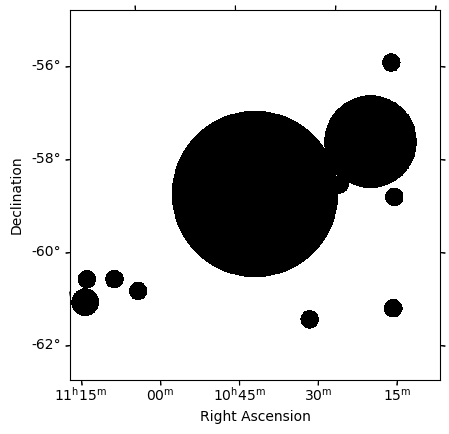

In [13]:
excl_regions_mask.sum_over_axes().plot()

In [15]:
thresh_bias = np.loadtxt('{}/bias_nsb_runs_below_160.txt'.format(outputBase))
thresh_bkg = np.loadtxt('{}/bkg_nsb_runs_below_160.txt'.format(outputBase))
threshold_energy = np.max(np.maximum(thresh_bias[:,1], thresh_bkg[:,1]))

print(threshold_energy)

0.8227


In [50]:
maker = MapDatasetMaker()
bias_percent = 5
maker_safe_mask = SafeMaskMaker(methods=['offset-max',
                                         'aeff-default',
                                         'aeff-max',
                                         'bkg-peak',
                                         'edisp-bias'
                                        ], offset_max=max_offset, bias_percent=bias_percent)

empty = MapDataset.create(geom, energy_axis_true=energy_axis_true)

stacked_name = 'Stacked-Ring-Bkg'
stacked = MapDatasetOnOff.create(geom=geom, name=stacked_name, energy_axis_true=energy_axis_true)

weird_bkg = []

for m in range(len(obs_list)):
    print(f'{m+1} of {len(obs_list)} runs to analyse')
    obs = obs_list[m]

    obs_id = obs.obs_id
    
    cutout = empty.cutout(obs.pointing.fixed_icrs, width=2*max_offset, name=f"obs-{obs.obs_id}")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    # number = find_energy_threshold(dataset) 

    # dataset.background = adjust_energy_threshold(dataset.background, number)
    # dataset.counts = adjust_energy_threshold(dataset.counts, number)

    maker_bkg = RingBackgroundMaker(r_in=1.6*u.deg,width=0.5*u.deg, exclusion_mask=excl_regions_mask) 
    dataset_on_off = maker_bkg.run(dataset)

    emask = energy_axis.edges.value[:-1] >= threshold_energy
    dataset_on_off.mask_safe.data[~emask, :, :] = False                   
    assert np.isfinite(dataset_on_off.background.data[dataset_on_off.mask_safe.data]).all()
    dataset_on_off.background.data[~dataset_on_off.mask_safe.data] = 0.0
    
    if dataset_on_off.info_dict()['excess'] > -1000:
        print(dataset_on_off.info_dict()['excess'])
        stacked.stack(dataset_on_off)   

    else:
        print(f'Weird bkg for Observation {obs_id}')
        weird_bkg.append(obs_id)

1 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


39.95704609091888
2 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-59.49979556555229
3 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


72.12115554949958
4 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


32.07995826519186
5 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-45.646588221407455
6 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


16.982133242445002
7 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


228.9255564644227
8 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-25.361376902767006
9 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-16.27797818118654
10 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-46.09542938269419
11 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


14.233532447287416
12 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


62.04821605586062
13 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


44.11672169524411
14 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


34.375218469523816
15 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


48.689151243650485
16 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


18.986289829856105
17 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


15.278763579151928
18 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


58.549673325170374
19 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


25.42471442961289
20 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


19.688058995174174
21 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


60.33346694324939
22 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-74.83894286691543
23 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


57.74445888586172
24 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


14.28652311106896
25 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


92.06732005066863
26 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


45.476267601070276
27 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


102.94400527027722
28 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


38.76488862383803
29 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


77.60746968610181
30 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


37.69623504773699
31 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


3.5946186129863236
32 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


6.288045609491064
33 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


87.83745093902542
34 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-20.265594655722794
35 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


37.71284842077364
36 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


2.8321942364924553
37 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


51.36092567953574
38 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


50.296035438017384
39 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


11.226959272753902
40 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


171.09497222701089
41 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


90.07529577441665
42 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


39.438964631299996
43 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


33.439147925333145
44 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-24.819643215177848
45 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


59.75160173100812
46 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


14.22610094638992
47 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


79.59162789384857
48 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


99.14846659300542
49 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


153.08464498860735
50 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


67.09057026127277
51 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


52.396564366694406
52 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


53.9415990642168
53 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-48.739805674353875
54 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


11.627823158849765
55 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-26.224971320712143
56 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


9.493163031208951
57 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


-12.201838689139208
58 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


30.748015515292423
59 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'


45.41082590655287


In [51]:
print(len(weird_bkg))

0


In [52]:
stacked

In [104]:
# stacked.write('/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_ring_bkg.fits.gz', overwrite=True)

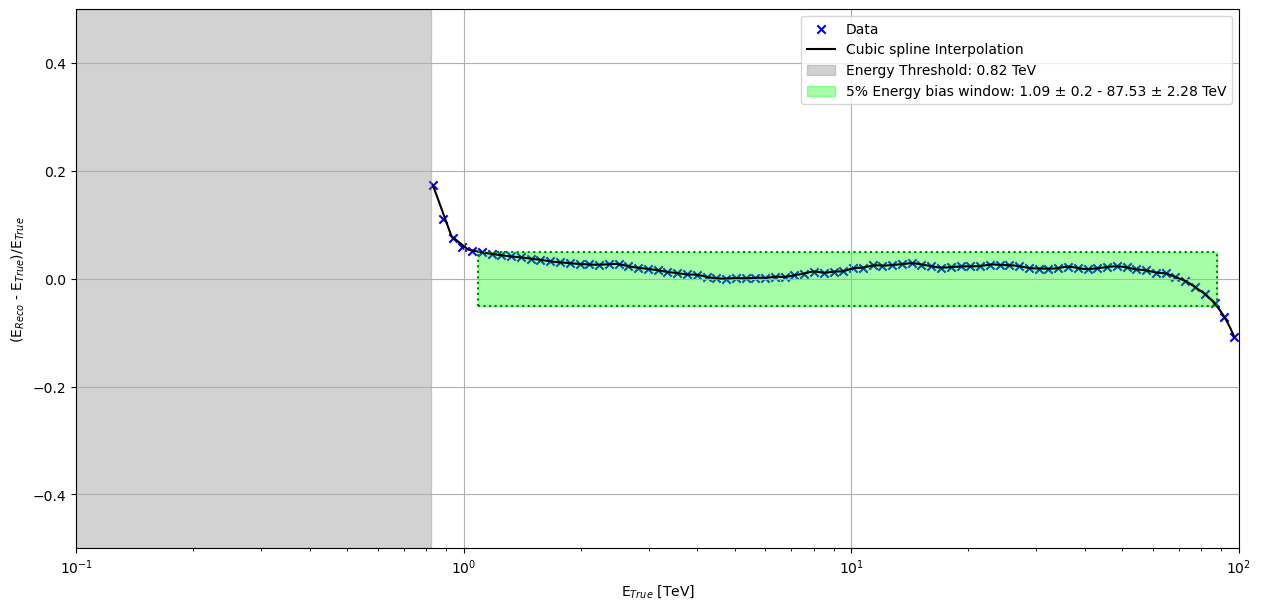

In [53]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.misc import derivative  # Import derivative for error propagation

# Obtain energy and bias data
energy = np.array(stacked.edisp.get_edisp_kernel().axes["energy_true"].center)
energy_min = stacked.energy_range_total[0].value
bias = np.array(stacked.edisp.get_edisp_kernel().get_bias(energy))

mask = (energy >= energy_min)

# Filtered data
x = energy[mask]
y = bias[mask]

# Create a cubic spline interpolation function with extrapolation
f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

# Find energies and errors for bias 0.05 and bias 0
bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, bias_percent*1e-2, initial_guess=0)
bias_energy_below_5_percent_high, error_high = find_energy_with_sensitivity(f_cubic, -bias_percent*1e-2, initial_guess=70.0)

# Plotting
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))

# Scatter plot of bias data
ax1.scatter(x, y, marker ='x', label='Data', color='blue')

# Interpolation plot
x_new = np.linspace(min(x), max(x), 1000)
y_new = f_cubic(x_new)
ax1.plot(x_new, y_new, label='Cubic spline Interpolation', color='black')

# Energy threshold area
ax1.axvspan(xmin=0, xmax=stacked.energy_range_total[0].value, color='grey', alpha=.35, label=f'Energy Threshold: {round(stacked.energy_range_total[0].value, 2)} TeV')

# Vertical lines for bias energy thresholds
ax1.vlines(bias_energy_below_5_percent_low, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')
ax1.vlines(bias_energy_below_5_percent_high, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')

# Horizontal lines for bias threshold
ax1.hlines(bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')
ax1.hlines(-bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')

# Label for the bias window
label_box = (f'{bias_percent}% Energy bias window: {round(bias_energy_below_5_percent_low, 2)} ± {round(error_low, 2)} - 'f'{round(bias_energy_below_5_percent_high, 2)} ± {round(error_high, 2)} TeV')
ax1.axvspan(xmin=bias_energy_below_5_percent_low, xmax=bias_energy_below_5_percent_high, ymin=0.45, ymax=.55, color='lime', alpha=.35, label=label_box)

# Set limits and labels
ax1.set_xlim(1e-1, 1e2)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('E$_{True}$ [TeV]')
ax1.set_ylabel(r'(E$_{Reco}$ - E$_{True}$)/E$_{True}$')
ax1.legend()
ax1.grid()
ax1.set_xscale('log')

# Save the figure if needed
# muf.save_figures(PlotDir, name='bias_stacked_dataset')

plt.show()

## $\sqrt{TS}$ map

In [14]:
dataset_000 = MapDatasetOnOff.read("/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_ring_bkg.fits.gz")

# c = SkyCoord(160.5, -59, unit='deg', frame='icrs')
# dataset_000 = dataset_000.cutout(c, width=(6,4)*u.deg)

In [38]:
dataset_000

In [41]:
dataset_fov = MapDataset.read("/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_fov_bkg_wide_fov_periastron_runs_and_runs_above_nsb_mean_eq_200_taken_out.fits.gz")

In [42]:
dataset_fov

### Grid

In [ ]:
# Energy edges from the dataset
energy_edges = np.array(dataset_000.counts.geom.axes['energy'].edges)

# Define lower bounds
lower_bounds = energy_edges[(energy_edges >= bias_energy_below_5_percent_low) & (energy_edges <= 5)]
upper_bound = bias_energy_below_5_percent_high  

# Create energy ranges with rounded lower bounds
energy_edges_list = [[round(lower, 2), upper_bound] * u.TeV for lower in lower_bounds]

# Dictionary to store results
significance_maps = {}

# Loop over energy edge sets and compute significance maps
for i, energy_edges in enumerate(energy_edges_list):
    estimator = ExcessMapEstimator(correlation_radius=.4 * u.deg, energy_edges=energy_edges)
    lima_maps = estimator.run(dataset_000)
    significance_maps[f"Energy_range_{round(energy_edges[0].value, 2)}-{round(energy_edges[1].value,2)}_TeV"] = lima_maps.sqrt_ts

In [ ]:
plt.figure(figsize=(30, 25))  # Adjust the overall figure size
num_maps = len(significance_maps)
ncols = 5 # Increase the number of columns for a tighter layout
nrows = (num_maps + ncols - 1) // ncols  # Calculate rows dynamically

# Create GridSpec with reduced spacing
gs = GridSpec(nrows, ncols, height_ratios=[1] * nrows, hspace=0.3, wspace=0.3)

axes = []

for i, (key, sig_map) in enumerate(significance_maps.items()):
    significance_array = np.squeeze(sig_map.data)
  
    ax=plt.subplot(gs[i // 5, i % 5], projection=sig_map.geom.wcs)

    marker_kwown_regions = dict(marker='*', color='black', markersize=4)
    # source_regions_plot(ax, catalog_4FGL_roi, marker_kwown_regions)
    
    sig_map.plot(ax=ax, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=7)

    # J1044_57 = SkyCoord(161.58, -58.23, unit='deg', frame='icrs')
    # ax.plot(J1044_57.ra.deg, J1044_57.dec.deg, '*', color='blue', transform=ax.get_transform('world'))

    J1046_58 = SkyCoord(162.05, -58.54, unit='deg', frame='icrs')
    ax.plot(J1046_58.ra.deg, J1046_58.dec.deg, '*', color='blue', transform=ax.get_transform('world'))
    
    cs = ax.contour(significance_array, levels=[5], colors="green", linewidths=.75)

    ax.set_title(f"{key.replace('_', ' ')}")

plt.tight_layout()

# muf.save_figures(PlotDir, name="sqrt_ts_maps_hard_cut_grid")

plt.show()

## Individual

In [33]:
# dataset_000 = dataset_001.copy()

# c = SkyCoord(162.07, -58.53, unit='deg', frame='icrs')
# dataset_000 = dataset_000.cutout(c, width=3*u.deg)

energy_mask = dataset_000.counts.geom.energy_mask(energy_min=1.16* u.TeV, energy_max=90 * u.TeV)

dataset_000.mask_fit = energy_mask

print(f'Analysing energy range from {dataset_000.energy_range_total[0].value} TeV to {dataset_000.energy_range_total[1].value} TeV')

estimator = ExcessMapEstimator(correlation_radius=.6 * u.deg, energy_edges=[1.16, 90]*u.TeV)
lima_maps = estimator.run(dataset_000)
significance_map = lima_maps.sqrt_ts
significance_array = np.squeeze(significance_map)
# significance_map = significance_map.cutout(target, width=(7,5)*u.deg)

Analysing energy range from 1.1689518164985782 TeV to 88.95134973108235 TeV


In [16]:
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.catalog import SourceCatalog4FGL
catalog_4FGL = SourceCatalog4FGL('/home/wecapstor1/caph/caph101h/software/miniforge3/bin/gammapy-datasets/1.2/catalogs/fermi/gll_psc_v32.fit.gz')
source_fermi_J1044 = catalog_4FGL["4FGL J1036.2-5936"]
mask_roi = source_fermi_J1044.position.separation(catalog_4FGL.positions) < 2.5 * u.deg

catalog_4FGL_roi = catalog_4FGL[mask_roi]
print("Number of sources :", len(catalog_4FGL_roi.table))

Number of sources : 15


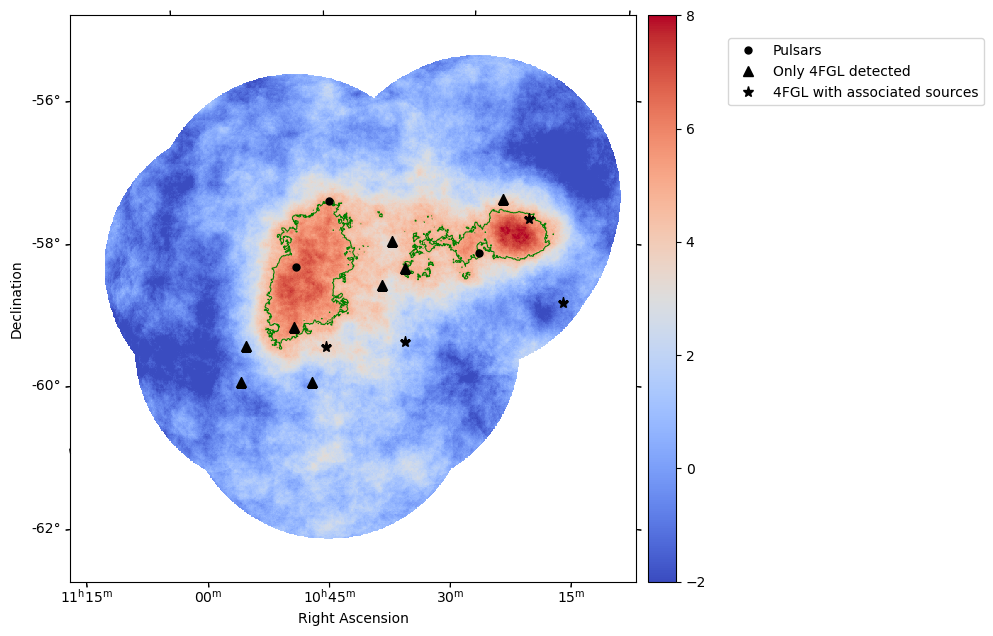

In [34]:
plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
################################################################################################################################
ax1 = plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)

significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=8)

marker_psr = dict(marker='o', color='black', markersize=5)
plot_position(ax1, 157.12, -58.32, '', marker_psr) # PSR J1028-5819
plot_position(ax1, 161.14, -57.62, '', marker_psr) # PSR J1044-5737 
plot_position(ax1, 162.05, -58.54, '', marker_psr) # PSR B1046-58 


psr_sources = ["4FGL J1028.5-5819", "4FGL J1044.4-5737", "4FGL J1048.2-5832"]

associated_source = ["4FGL J1018.9-5856", "4FGL J1023.3-5747e", "4FGL J1036.2-5936", "4FGL J1045.1-5940"]

marker_4fgl_unassociated_sources = dict(marker='^', color='black', markersize=7)
marker_4fgl_associated_sources = dict(marker='*', color='black', markersize=8)

for models in catalog_4FGL_roi.to_models():
    if (models.name not in psr_sources) & (models.name not in associated_source):
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_unassociated_sources)
    elif models.name in associated_source:
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_associated_sources)       

ax1.contour(significance_array, levels=[5], colors="green", linewidths = .75, zorder=0)


legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=5, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='^', color='black', markersize=7, linestyle='None', label='Only 4FGL detected'),
    Line2D([0], [0], marker='*', color='black', markersize=8, linestyle='None', label='4FGL with associated sources')
]

ax1.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

# muf.save_figures(PlotDir, name="sqrt_ts_map_ring_with_fermi_sources")

plt.show()

[12514.271621029677, -0.0037812779369870075, 1.3008525313915567]
[162.30529267406612, 0.019481441156019023, 0.01948148194570409]


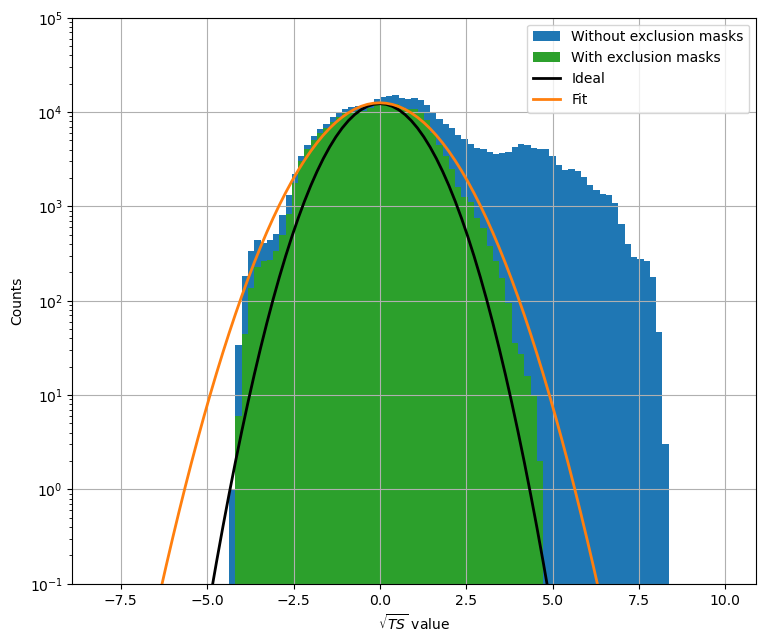

In [37]:
plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  

ax2 = plt.subplot(gs[0,1])
excl_data = significance_map.geom.region_mask(regions=excl_regions, inside=False)
significance_map_excl = significance_map * excl_data
significance_data_excl = significance_map_excl.data[np.isfinite(significance_map_excl.data)]
significance_map_excl.data[~excl_data] = np.nan
significance_data = significance_map_excl.data[np.isfinite(significance_map_excl.data)]

significance_data_no_exclusion = significance_map.data[np.isfinite(significance_map.data)]

bins = np.linspace(-8, 10, 100)
ax2.hist(significance_data_no_exclusion, bins=bins, color='tab:blue', alpha=1, lw=2, zorder=0, label="Without exclusion masks")
n, bins_, _ = ax2.hist(significance_data, bins=bins, color='tab:green', alpha=1, lw=2, zorder=1, label="With exclusion masks")
x_vals = 0.5 * (bins_[:-1] + bins_[1:])
mu, std = norm.fit(significance_data)
y = norm.pdf(x_vals, mu, std) * sum(n * np.diff(bins_))

y_theo = gaussian(bins, np.max(n), 0, 1)#norm.pdf(x_vals, 0, 1) * sum(n * np.diff(bins_))


fit, error = fit_gaussian(x_vals, n)
print([item for item in fit])
print([item for item in error])

# ax2.plot(x_vals, y, lw=2, color="black",label=r"Fit".format(mu, std))
ax2.plot(bins, y_theo, lw=2,color="black", label=r"Ideal")
ax2.plot(bins, gaussian(bins, *fit), lw=2, color="tab:orange", label='Fit')

ax2.legend()
#ax2.set_xlim(-5, 5)
ax2.set_ylim(1e-1, 1e5)
ax2.set_xlabel(r'$\sqrt{TS}$ value')
ax2.set_ylabel('Counts')
ax2.grid()

ax2.set_yscale('log')

# muf.save_figures(PlotDir, name='sqrt_ts_map_ring_histogram')

plt.show()

Set MJD-END to 57176.988647 from DATE-END'. [astropy.wcs.wcs]


NameError: name 'excl_regions' is not defined

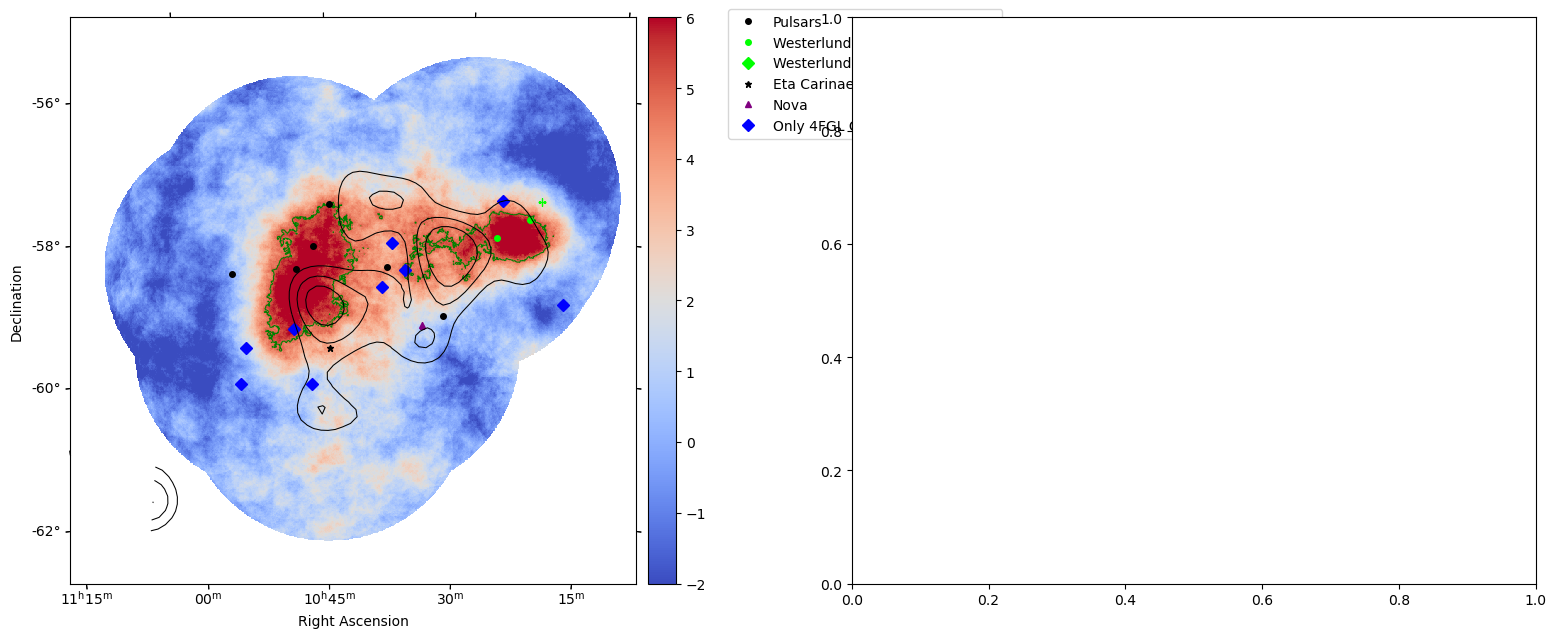

In [21]:
sigma_level = [5]
color = ['green']
significance_array = np.squeeze(significance_map)
contour_legend = Line2D([0], [0], color=color[0], label=rf'{sigma_level[0]}$\sigma$')

plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
################################################################################################################################
ax1 = plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)


significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=6)

ax1.contour(significance_array, levels=sigma_level, colors=color, linewidths = .75)

marker_psr = dict(marker='o', color='black', markersize=4)
plot_position(ax1, 162.05, -58.54, '', marker_psr) # PSR B1046-58
plot_position(ax1, 161.58, -58.23, '', marker_psr) # PSR B1044-57
plot_position(ax1, 163.78, -58.58, '', marker_psr) # PSR J1057-5851
plot_position(ax1, 161.14, -57.63, '', marker_psr) # PSR J1044-5737
plot_position(ax1, 159.58, -58.52, '', marker_psr) # PSR B1036-58
plot_position(ax1, 158.02, -59.20, '', marker_psr) # PSR B1030-58


marker_westerlund_psr = dict(marker='o', color='lime', markersize=4)
marker_westerlund = dict(marker='+', color='lime', markersize=6)
plot_position(ax1, 155.81, -57.78, '', marker_westerlund_psr) # PSR J1023-5746 # Westerlund 2 extended region
plot_position(ax1, 156.65, -58.06, '', marker_westerlund_psr) # PSR J1028-5819 # Westerlund 2 extended region
plot_position(ax1, 155.53, -57.51, '', marker_westerlund) # Cl Westerlund 2

marker_eta_car = dict(marker='*', color='black', markersize=5)
plot_position(ax1, 161.15, -59.67, '', marker_eta_car) # Eta Carinae

marker_nova = dict(marker='^', color='purple', markersize=4)
plot_position(ax1, 158.59, -59.34, '', marker_nova) # V* V906 Car -- Classical Nova

# marker_blazar = dict(marker='o', color='orange', markersize=4)
# plot_position(ax1, 161.29, -55.03, '', marker_blazar) # 4FGL J1047.2-5517 -- Blazar Candidate
# plot_position(ax1, 165.20, -56.21, '', marker_blazar) # 4FGL J1102.9-5628 -- Blazar Candidate


# Define legend handles for each marker type
legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=4, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='o', color='lime', markersize=4, linestyle='None', label='Westerlund Pulsars'),
    Line2D([0], [0], marker='D', color='lime', markersize=6, linestyle='None', label='Westerlund emission'),
    Line2D([0], [0], marker='*', color='black', markersize=5, linestyle='None', label='Eta Carinae'),
    Line2D([0], [0], marker='^', color='purple', markersize=4, linestyle='None', label='Nova'),
    Line2D([0], [0], marker='D', color='blue', markersize=6, linestyle='None', label='Only 4FGL Gamma-ray emission'),
]

# Add the legend to the plot
ax1.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

associated_sources_dict = {"Pulsar": ["4FGL J1048.2-5832", "4FGL J1044.4-5737", "4FGL J1023.0-5745", "4FGL J1028.5-5819", "4FGL J1056.9-5852"],
                           "Nova": ["4FGL J1036.2-5936"],
                           "Blazar Candidate": ["4FGL J1047.2-5517", "4FGL J1102.9-5628"],
                           "Westerlund Extended": ["4FGL J1023.3-5747e"],
                           "Eta Carinae": ["4FGL J1045.1-5940"]}
 
# associated_sources description:
#     4FGL J1048.2-5832: PSR B1046-58 162.05, -58.54
#     4FGL J1044.4-5737: PSR B1044-57 161.58, -58.23
#     4FGL J1023.0-5745: PSR J1023-5746 155.81, -57.78
#     4FGL J1028.5-5819: PSR J1028-5819 156.65, -58.06
#     4FGL J1056.9-5852: PSR J1057-5851 163.78, -58.58
#     --               : PSR J1044-5737 161.14, -57.63
#     --               : PSR B1036-58 159.58, -58.52
#     --               : PSR B1030-58 158.02, -59.20

#     4FGL J1045.1-5940 Eta Carinae -- Blue Supergiant 	160.78 ,-59.42
#     4FGL J1023.3-5747e: Cl Westerlund 2 155.53, -57.51

#     4FGL J1036.2-5936: V* V906 Car -- Classical Nova 158.59, -59.34
#     4FGL J1047.2-5517: 4FGL J1047.2-5517 -- Blazar Candidate 161.29,-55.03
#     4FGL J1102.9-5628: 4FGL J1102.9-5628 -- Blazar Candidate 165.20, -56.21

marker_unassociated_sources = dict(marker='D', color='blue', markersize=6)


for models in catalog_4FGL_roi.to_models():
    # Check if the source is associated
    is_associated = any(
        models.name in source_list for source_list in associated_sources_dict.values()
    )

    if not is_associated:  
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_unassociated_sources) 

# source_regions_plot(ax1, catalog_4FGL_roi, marker_kwown_regions)

# Load the TS map from the FITS file
ts_file = "ts10.fits"
with fits.open(ts_file) as hdul:
    ts_data = hdul[0].data  # Extract the data array
    ts_header = hdul[0].header  # Extract the WCS header

# Create a WCS object from the header
ts_wcs = WCS(ts_header)

# Smooth the TS data
smoothed_ts_data = gaussian_filter(ts_data, sigma=2.97)

# Define the contour levels and colors
contour_levels = [3.0, 4.0, 5.0]
contour_color = "black"

# Plot contours on the existing axis (assumes `ax1` has the correct WCS projection)
ax1.contour(smoothed_ts_data, transform=ax1.get_transform(ts_wcs), 
            levels=contour_levels, colors=contour_color, linewidths=0.75)

################################################################################################################################
ax2 = plt.subplot(gs[0,1])
excl_data = significance_map.geom.region_mask(regions=excl_regions, inside=False)
significance_map_excl = significance_map * excl_data
significance_data_excl = significance_map_excl.data[np.isfinite(significance_map_excl.data)]
significance_map_excl.data[~excl_data] = np.nan
significance_data = significance_map_excl.data[np.isfinite(significance_map_excl.data)]

bins = np.linspace(-8, 8, 100)
n, bins_, _ = ax2.hist(significance_data, bins=bins, color='green', alpha=0.6, lw=2, zorder=1)
x_vals = 0.5 * (bins_[:-1] + bins_[1:])
mu, std = norm.fit(significance_data)
y = norm.pdf(x_vals, mu, std) * sum(n * np.diff(bins_))

y_theo = norm.pdf(x_vals, 0, 1) * sum(n * np.diff(bins_))

ax2.plot(x_vals, y, lw=2, color="black", label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std))
ax2.plot(x_vals, y_theo, lw=2, color="orange", label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(0, 1))

ax2.set_title('$\sqrt{TS}$ with exclusion masks')
ax2.legend()
#ax2.set_xlim(-5, 5)
ax2.set_ylim(1e0, 1e5)
ax2.set_xlabel(r'$\sqrt{TS}$')
ax2.set_ylabel('Counts')
ax2.grid()

ax2.set_yscale('log')

# muf.save_figures(PlotDir, name='sqrt_ts_map_with_contours_overlaid')

plt.show()